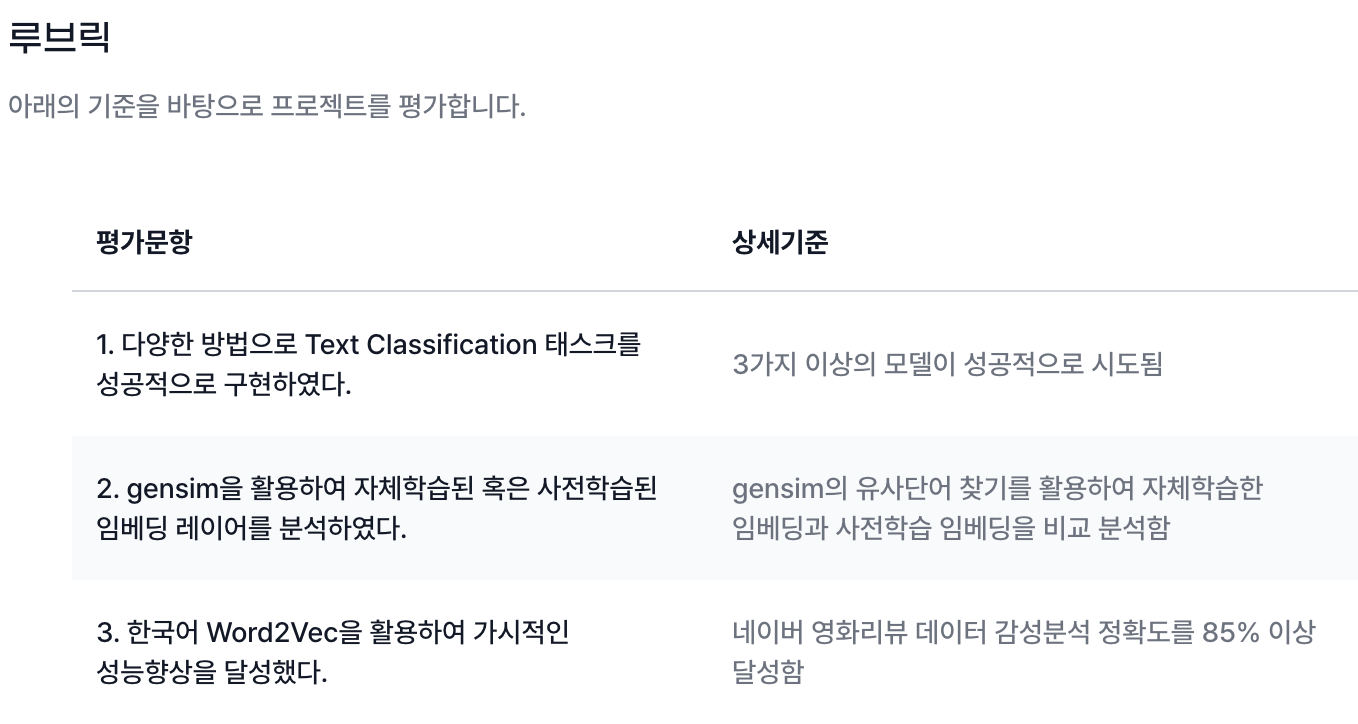

In [1]:
!ln -s ~/data/*.txt /aiffel/aiffel/workspace/11_study/quest/data

ln: failed to create symbolic link '/aiffel/aiffel/workspace/11_study/quest/data/ratings_test.txt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/workspace/11_study/quest/data/ratings_train.txt': File exists


# 데이터 load

In [2]:
# 라이브러리 import
import pandas as pd
import konlpy
import gensim

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf

In [3]:
train_data = pd.read_table('/aiffel/aiffel/workspace/11_study/quest/data/ratings_train.txt')
test_data = pd.read_table('/aiffel/aiffel/workspace/11_study/quest/data/ratings_test.txt')

print(train_data.head())
# id, document(리뷰임), label(target) 3개 컬럼 존재
print('train shape',train_data.shape)
print('test shape',test_data.shape)

         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
train shape (150000, 3)
test shape (50000, 3)


In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        # 사전에 없는건 <UNK>
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
print('word_to_index')
print(word_to_index)
index_to_word = {index:word for word, index in word_to_index.items()}
print('index_to_word')
print(index_to_word)

word_to_index
{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, '<UNUSED>': 3, '.': 4, '영화': 5, '다': 6, '고': 7, '하': 8, '을': 9, '보': 10, '..': 11, '게': 12, ',': 13, '!': 14, '지': 15, '있': 16, '없': 17, '?': 18, '좋': 19, '나': 20, '었': 21, '만': 22, '는데': 23, '너무': 24, '봤': 25, '적': 26, '안': 27, '정말': 28, '로': 29, '음': 30, '것': 31, '아': 32, '네요': 33, '재밌': 34, '어': 35, '같': 36, '점': 37, '지만': 38, '진짜': 39, '했': 40, '에서': 41, '기': 42, '네': 43, '않': 44, '거': 45, '았': 46, '수': 47, '되': 48, '면': 49, 'ㅋㅋ': 50, '말': 51, '연기': 52, '인': 53, '주': 54, '내': 55, '최고': 56, '~': 57, '평점': 58, '이런': 59, '던': 60, '어요': 61, '할': 62, '왜': 63, '겠': 64, '1': 65, '스토리': 66, '해': 67, '습니다': 68, 'ㅋㅋㅋ': 69, '...': 70, '드라마': 71, '생각': 72, '아니': 73, '더': 74, '그': 75, '싶': 76, '사람': 77, '듯': 78, '때': 79, '감동': 80, '함': 81, '배우': 82, '본': 83, '까지': 84, '뭐': 85, '알': 86, '만들': 87, '내용': 88, '볼': 89, '감독': 90, '보다': 91, '라': 92, '그냥': 93, '재미': 94, '시간': 95, '지루': 96, '중': 97, '재미있': 98, '년': 99, '10': 100, '였': 101, '잼': 102, '사랑

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# max review 길이 구하기

In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이 평균, 최대, 표준편차
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2.5*표준편차)
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {100 * np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  48
전체 문장의 95.48784420929768%가 maxlen 설정값 이내에 포함. 


# LSTM으로 학습 & 자체 임베딩

In [8]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # LSTM이라 pre
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # LSTM이라 pre
                                                       maxlen=maxlen)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(146182, 48)
(146182,)
(49157, 48)
(49157,)


## train 데이터셋 train, val로 쪼개기

In [9]:
# validation set 117000 분리 (8:2정도로)
x_val = X_train[:117000]   
y_val = y_train[:117000]

# validation set을 제외한 나머지 29182건
partial_x_train = X_train[117000:]  
partial_y_train = y_train[117000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(29182, 48)
(29182,)


## 모델 구성

In [10]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,758,161
Trainable params: 2,758,161
Non-trainable params: 0
_________________________________________________________________


## LSTM 학습 & 자체 임베딩

In [11]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss')]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
286/286 [==============================] - 9s 19ms/step - loss: 0.3961 - accuracy: 0.8221 - val_loss: 0.3038 - val_accuracy: 0.8715
Epoch 2/20
286/286 [==============================] - 5s 18ms/step - loss: 0.3089 - accuracy: 0.8677 - val_loss: 0.2645 - val_accuracy: 0.8912
Epoch 3/20
286/286 [==============================] - 5s 18ms/step - loss: 0.2702 - accuracy: 0.8857 - val_loss: 0.2289 - val_accuracy: 0.9094
Epoch 4/20
286/286 [==============================] - 5s 18ms/step - loss: 0.2406 - accuracy: 0.8999 - val_loss: 0.2037 - val_accuracy: 0.9201
Epoch 5/20
286/286 [==============================] - 5s 18ms/step - loss: 0.2158 - accuracy: 0.9112 - val_loss: 0.1771 - val_accuracy: 0.9314
Epoch 6/20
286/286 [==============================] - 5s 18ms/step - loss: 0.1904 - accuracy: 0.9233 - val_loss: 0.1649 - val_accuracy: 0.9381
Epoch 7/20
286/286 [==============================] - 5s 19ms/step - loss: 0.1698 - accuracy: 0.9322 - val_loss: 0.1360 - val_accuracy: 0.9482

### LSTM 모델 평가 & 자체 임베딩 & 시각화

In [12]:
# test 셋으로 모델 평가
model.evaluate(X_test,  y_test)

1537/1537 [==============================] - 4s 3ms/step - loss: 0.9510 - accuracy: 0.8465


[0.9509657025337219, 0.8465121984481812]

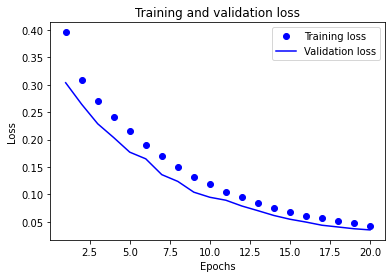

In [13]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

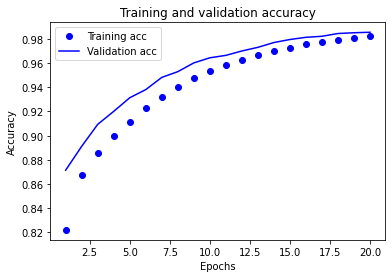

In [14]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## gensim으로 자체 학습 임베딩 비교

In [15]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
my_vec_file_path = '/aiffel/aiffel/workspace/11_study/quest/data/my_vec.txt'

f = open(my_vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [16]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(my_vec_file_path, binary=False)

In [17]:
# 전체 확인
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시

In [18]:
word_vectors.similar_by_word("아름다운")

[('I', 0.81336909532547),
 ('정점', 0.8043902516365051),
 ('비판', 0.7951220870018005),
 ('역작', 0.7851099967956543),
 ('감탄', 0.7848565578460693),
 ('스마트폰', 0.7814225554466248),
 ('최고', 0.7810420989990234),
 ('진화', 0.7746317982673645),
 ('누군가', 0.7732309699058533),
 ('은근', 0.7729639410972595)]

In [19]:
word_vectors.similar_by_word("강추")

[('수준급', 0.7450218796730042),
 ('명작', 0.7443320155143738),
 ('엄연히', 0.7437312006950378),
 ('숀', 0.7431942224502563),
 ('먹먹', 0.7420152425765991),
 ('기다려', 0.738813579082489),
 ('스마트폰', 0.7387462258338928),
 ('숨막히', 0.7359071969985962),
 ('신선', 0.7352216243743896),
 ('깊', 0.7312242984771729)]

In [20]:
word_vectors.similar_by_word("따뜻")

[('밋', 0.7428345680236816),
 ('우리나라', 0.715945839881897),
 ('요원', 0.7104822397232056),
 ('화이팅', 0.7032687664031982),
 ('편한', 0.7020779848098755),
 ('가슴', 0.6998959183692932),
 ('very', 0.6896129250526428),
 ('떠서', 0.685832679271698),
 ('직설', 0.6764528155326843),
 ('곁', 0.6744453310966492)]

In [21]:
word_vectors.similar_by_word("답답")

[('유치', 0.727519154548645),
 ('발연기', 0.7191106081008911),
 ('재미없', 0.7142564058303833),
 ('발음', 0.7127930521965027),
 ('별로', 0.7066948413848877),
 ('클리셰', 0.7059109807014465),
 ('아녀', 0.7041472792625427),
 ('만드세요', 0.7040891647338867),
 ('불친절', 0.6961336731910706),
 ('바', 0.6893178224563599)]

## 한국어 Word2Vec로 임베딩 활용하여 성능 개선해보기 (CNN 활용)

In [22]:
!ln -s ~/data/word2vec_ko.model* /aiffel/aiffel/workspace/11_study/quest/data

ln: failed to create symbolic link '/aiffel/aiffel/workspace/11_study/quest/data/word2vec_ko.model': File exists
ln: failed to create symbolic link '/aiffel/aiffel/workspace/11_study/quest/data/word2vec_ko.model.trainables.syn1neg.npy': File exists
ln: failed to create symbolic link '/aiffel/aiffel/workspace/11_study/quest/data/word2vec_ko.model.wv.vectors.npy': File exists


In [23]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = '/aiffel/aiffel/workspace/11_study/quest/data/word2vec_ko.model'
    
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

vector = word_vectors.wv["끝"]
print('shape',vector.shape)
print('총갯수',len(word_vectors.wv))


shape (100,)
총갯수 302960


In [24]:
word_vectors.wv.similar_by_word('love')

[('your', 0.9268641471862793),
 ('you', 0.9266151785850525),
 ('never', 0.9243075847625732),
 ('Once', 0.9185521006584167),
 ('again', 0.9132663607597351),
 ('But', 0.9090688228607178),
 ('Keep', 0.907763659954071),
 ('my', 0.9073383808135986),
 ('Eat', 0.9046016335487366),
 ('If', 0.9043469429016113)]

In [25]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 100)           1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 42, 16)            11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [26]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss')]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
286/286 [==============================] - 4s 7ms/step - loss: 0.5877 - accuracy: 0.6776 - val_loss: 0.5020 - val_accuracy: 0.7534
Epoch 2/20
286/286 [==============================] - 2s 6ms/step - loss: 0.4684 - accuracy: 0.7766 - val_loss: 0.4259 - val_accuracy: 0.8034
Epoch 3/20
286/286 [==============================] - 2s 6ms/step - loss: 0.4149 - accuracy: 0.8075 - val_loss: 0.3866 - val_accuracy: 0.8236
Epoch 4/20
286/286 [==============================] - 2s 6ms/step - loss: 0.3827 - accuracy: 0.8253 - val_loss: 0.3609 - val_accuracy: 0.8370
Epoch 5/20
286/286 [==============================] - 2s 6ms/step - loss: 0.3598 - accuracy: 0.8377 - val_loss: 0.3369 - val_accuracy: 0.8503
Epoch 6/20
286/286 [==============================] - 2s 6ms/step - loss: 0.3419 - accuracy: 0.8469 - val_loss: 0.3234 - val_accuracy: 0.8571
Epoch 7/20
286/286 [==============================] - 2s 6ms/step - loss: 0.3281 - accuracy: 0.8539 - val_loss: 0.3079 - val_accuracy: 0.8652
Epoch 

## 사전 학습된 word2vec 임베딩 & CNN 모델 평가

In [27]:
# test 셋으로 모델 평가
model.evaluate(X_test,  y_test)

1537/1537 [==============================] - 3s 2ms/step - loss: 0.5419 - accuracy: 0.8050


[0.5419204831123352, 0.804992139339447]

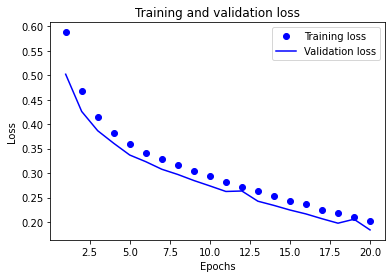

In [28]:
# 시각화
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

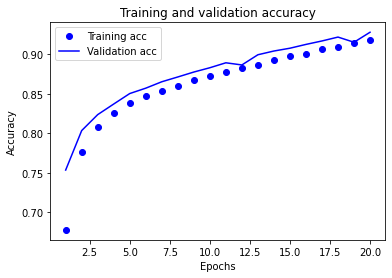

In [29]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 사전 학습된 임베딩 활용하여 성능 개선해보기 (CNN 활용)

In [30]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = '/aiffel/aiffel/workspace/11_study/quest/data/word2vec_ko.model'
    
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

In [31]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

# 모델 구성
model = tf.keras.Sequential()

# 사전 임베딩 활용
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)

model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,118,289
Trainable params: 1,118,289
Non-trainable params: 0
_________________________________________________________________


In [32]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss')]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
286/286 [==============================] - 6s 16ms/step - loss: 0.4577 - accuracy: 0.7811 - val_loss: 0.3529 - val_accuracy: 0.8455
Epoch 2/20
286/286 [==============================] - 4s 14ms/step - loss: 0.3403 - accuracy: 0.8508 - val_loss: 0.3007 - val_accuracy: 0.8731
Epoch 3/20
286/286 [==============================] - 4s 14ms/step - loss: 0.2952 - accuracy: 0.8737 - val_loss: 0.2618 - val_accuracy: 0.8911
Epoch 4/20
286/286 [==============================] - 4s 14ms/step - loss: 0.2656 - accuracy: 0.8888 - val_loss: 0.2474 - val_accuracy: 0.9002
Epoch 5/20
286/286 [==============================] - 4s 14ms/step - loss: 0.2426 - accuracy: 0.9001 - val_loss: 0.2130 - val_accuracy: 0.9162
Epoch 6/20
286/286 [==============================] - 4s 14ms/step - loss: 0.2201 - accuracy: 0.9111 - val_loss: 0.1890 - val_accuracy: 0.9283
Epoch 7/20
286/286 [==============================] - 4s 14ms/step - loss: 0.2002 - accuracy: 0.9201 - val_loss: 0.1673 - val_accuracy: 0.9370

## 사전 학습된 임베딩 & CNN 모델 평가

In [33]:
# 자체 임베딩은 0.8465121984481812 이 나왔었음

# test 셋으로 모델 평가
model.evaluate(X_test,  y_test)

1537/1537 [==============================] - 4s 3ms/step - loss: 0.8017 - accuracy: 0.8511


[0.8017340302467346, 0.8510690331459045]

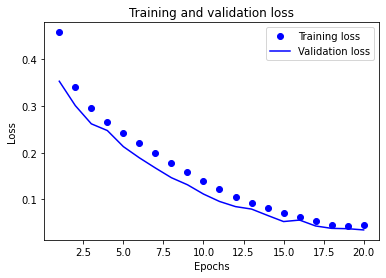

In [34]:
# 시각화
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

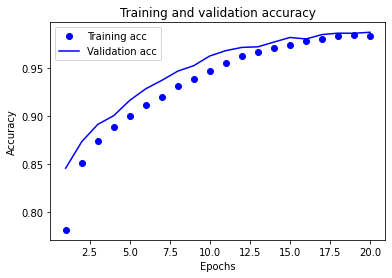

In [35]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고

- 배운 점
    - 단어 사전, 임베딩 공간을 직접 만드는 방법
- 아쉬운 점
    - 좀더 다양하게 keras 튜너를 이용한다던가 하는 방법으로 하이퍼파라미터를 변경하고 싶었는데 그렇게 하기에는 시간이 부족했다.
- 느낀 점
    - 사전에 잘 학습된 임베딩 공간을 잘 활용하는것만으로도 모델 성능을 올릴 수 있다.
- 어려웠던 점
```python
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
```
이부분에서 처음에는 data 밑의 word2vec_ko.model 모델만 링크를 걸어줬다가 load가 안됬었는데 나머지 .model.trainables~.npy와 .model.wv~.npy 를 같이 링크를 걸어줫더니 load 가 잘됬었다 좀 헤멨었다^^.